In [ ]:
import scanpy as sc
import os
os.chdir('/mnt/data1/wangj/AgingScore/GSE163530_COVID-19/GSE171668_scnRNA/')

In [ ]:
organs = ['lung', 'kidney', 'liver', 'heart']

In [ ]:
import pandas as pd
mm_l2 = pd.read_csv('/home/wangjing/wangj/AgingScore/AgingScorePro/l2.csv',index_col=0)
mm_l2.head()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(Data_raw[organs[3]].X.sum(axis=1).flatten().tolist()[0])

In [ ]:
Data_raw = {}
Data = {}

In [ ]:
import numpy as np
for organ in ['heart']:
    ### load data
    adata = sc.read_h5ad(organ+'.h5ad')
    Data_raw[organ] = adata.copy()
    adata.obs['norm_counts'] = adata.X.sum(axis=1).flatten().tolist()[0]

    ### remove cells with high ribosome gene expression
    try:
        adata.obs['percent_ribo'] = adata.raw.X[:,(adata.var_names.str.startswith('RPS') | adata.var_names.str.startswith('RPL'))].sum(axis=1).flatten().tolist()[0]/adata.obs['n_UMI']
    except:
        adata.obs['percent_ribo'] = adata.raw.X[:,(adata.var_names.str.startswith('RPS') | adata.var_names.str.startswith('RPL'))].sum(axis=1).flatten().tolist()[0]/adata.obs['n_counts']
    adata = adata[adata.obs['percent_ribo']<0.05,:]

    ### filter genes with acceptable mean expression level
    mean_exp = np.array(adata.X.mean(axis=0).flatten().tolist()[0])
    features = adata.var_names[mean_exp > np.quantile(mean_exp,0.75)]
    genes = set(mm_l2.index) & set(features) 
    model_use = mm_l2.loc[list(genes),]

    exp = adata[:,list(genes)].X.todense()
    exp = pd.DataFrame(exp,index=adata.obs_names,columns=list(genes))

    ### calculate hUSI
    hUSI = []
    for row in range(len(exp)):  
        hUSI.append(model_use.w.corr(exp.iloc[row],method='spearman'))
    adata.obs['hUSI'] = hUSI
    print(adata.obs['hUSI'].corr(adata.obs['norm_counts']))
    Data[organ] = adata
    
    

In [ ]:
import pickle

with open('MutiOrgans.pkl', 'wb') as file:
    pickle.dump(Data, file)

In [ ]:
os.chdir('/home/wangjing/wangj/codebase/HUSI/Figures/covid-19_1010')
for organ in organs:
    sc.set_figure_params(dpi=300, dpi_save=300, format='png')
    sc.pl.umap(Data[organ], color=['hUSI'], size=10, legend_loc='on data', palette='Blues', ncols=2, use_raw=False, save=organ+'_hUSI.png',show=False)

In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

import collections as clt
for organ in organs:
    mclust = importr('mclust')
    data = Data[organ].obs['hUSI'].tolist()
    r_data = FloatVector(data)
    result = mclust.Mclust(r_data)

    clusters = result.rx2('classification')
    clusters = list(clusters)

    print(clt.Counter(clusters))

    Data[organ].obs['age_class'] = pd.Categorical(clusters)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

for organ in organs:
    sc.set_figure_params(dpi=50)
    plt.figure(figsize=(5,5))
    sns.boxplot(x='age_class',y='hUSI',data=Data[organ].obs)
    plt.title(organ)
    plt.show()

In [ ]:
sc.pl.umap(Data[organs[2]],color='hUSI')

In [ ]:
organ = organs[1]
organ 

In [ ]:
df_plot = pd.DataFrame(columns=['donor','age_class','count','Fraction','organ'])
for organ in organs:
    df = Data[organ].obs[['age_class','donor']]
    df['donor'] = pd.Categorical([s.split('_')[0] for s in df['donor']])
    df = df.groupby(['donor','age_class']).size().reset_index().rename(columns={0:'count'})
    df['Fraction'] = df['count'] / df.groupby(['donor'])['count'].transform('sum')
    df = df[df.age_class == df.age_class.astype('int').max()]
    df['organ'] = organ
    df = df.sort_values(by='Fraction',ascending=False)
    df_plot = pd.concat([df_plot,df])

In [ ]:
ClinicMeta = pd.read_csv('/home/wangjing/wangj/AgingScore/GSE163530_COVID-19/GSE162911_GeoMx/ClinicMeta.csv',index_col=0)
df_plot['DTD'] = ClinicMeta.loc[df_plot['donor'].values,'Days_to_death'].values
# df_plot['Age'] = ClinicMeta.loc[df_plot['donor'].values,'Age'].values
# df_plot['Sex'] = ClinicMeta.loc[df_plot['donor'].values,'Sex'].values
# df_plot['IMV'] = ClinicMeta.loc[df_plot['donor'].values,'IMV_days'].values
df_plot

In [ ]:
df_plot.donor = pd.Categorical(df_plot.donor,categories=df_plot.sort_values(by='DTD',ascending=False).donor.unique(),ordered=True)
# df_plot.Age.replace('75-79','75-80',inplace=True)
# df_plot.Age = pd.Categorical(df_plot.Age,categories=['30-35', '40-45','50-55','55-60','60-65','65-70', '70-75','75-80','80-85','>89'],ordered=True)
# df_plot.donor = pd.Categorical(df_plot.donor,categories=df_plot.sort_values(by='Age',ascending=True).donor.unique(),ordered=True)
df_plot

In [ ]:
sns.set(rc={'figure.figsize':(8,6)},font_scale=1.5)
sns.set_style('white')
sns.scatterplot(x='donor',y='Fraction',hue='organ',data=df_plot,s = 150,alpha = 0.8,palette='Set1')
plt.ylabel('Fraction')
plt.xlabel('Donor')
plt.xticks(rotation = 90)
plt.savefig('/home/wangjing/wangj/codebase/HUSI/Figures/covid-19_1010/figures/Fraction_Donor.png',dpi=300)
plt.show()

In [ ]:
ClinicMeta.Days_to_death.median()

In [ ]:
df_plot['Progress'] = pd.Categorical(['severe' if i <  15 else 'moderate' for i in df_plot.DTD],categories=['moderate','severe'],ordered=True)

In [ ]:
sns.set(rc={'figure.figsize':(8,5)},font_scale=1.5)
sns.set_style('white')
sns.boxplot(hue='Progress',y='Fraction',x='organ',data=df_plot,palette=['#1d3557','#e63946'],linewidth=2.5)
plt.ylabel('Fraction')
plt.xlabel('Donor')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
adata = Data['lung']
adata.obs['Donor'] = adata.obs['donor'].str.split("_").str.get(0)
adata.obs['DTD'] = ClinicMeta.loc[adata.obs['Donor'].values,'Days_to_death'].values

In [ ]:
df_plot = Data['lung'].obs[['Cluster','Donor','hUSI','DTD']].copy()
df_plot['Group'] = df_plot['Donor']
df_plot = df_plot.groupby(['Cluster','Group']).mean().reset_index()
df_plot.fillna(0,inplace=True)
mat = df_plot.pivot(index='Cluster',columns='Group',values='hUSI').to_numpy()

In [ ]:
sns.clustermap(mat, cmap='coolwarm', metric='euclidean', method='average',figsize=(8,6),cbar_kws={'label': 'hUSI'},
               xticklabels=df_plot.Group.unique(),
               yticklabels=df_plot.Cluster.cat.categories)
plt.savefig('/home/wangjing/wangj/codebase/HUSI/Figures/covid-19_1010/figures/Clustermap.png',dpi=300)
plt.show() 

In [ ]:
import scipy
label = adata.obs.Cluster.cat.categories.to_list()
corr = [scipy.stats.spearmanr(adata.obs[adata.obs.Cluster == i].hUSI,adata.obs[adata.obs.Cluster == i].DTD) for i in adata.obs.Cluster.cat.categories]

In [ ]:
c = []
p = []
for i in range(len(corr)):
    c.append(corr[i][0])
    if corr[i][1] == 0:
        p.append(260)
    else:
        p.append(-np.log(corr[i][1]))
    print(label[i],c[i],p[i])

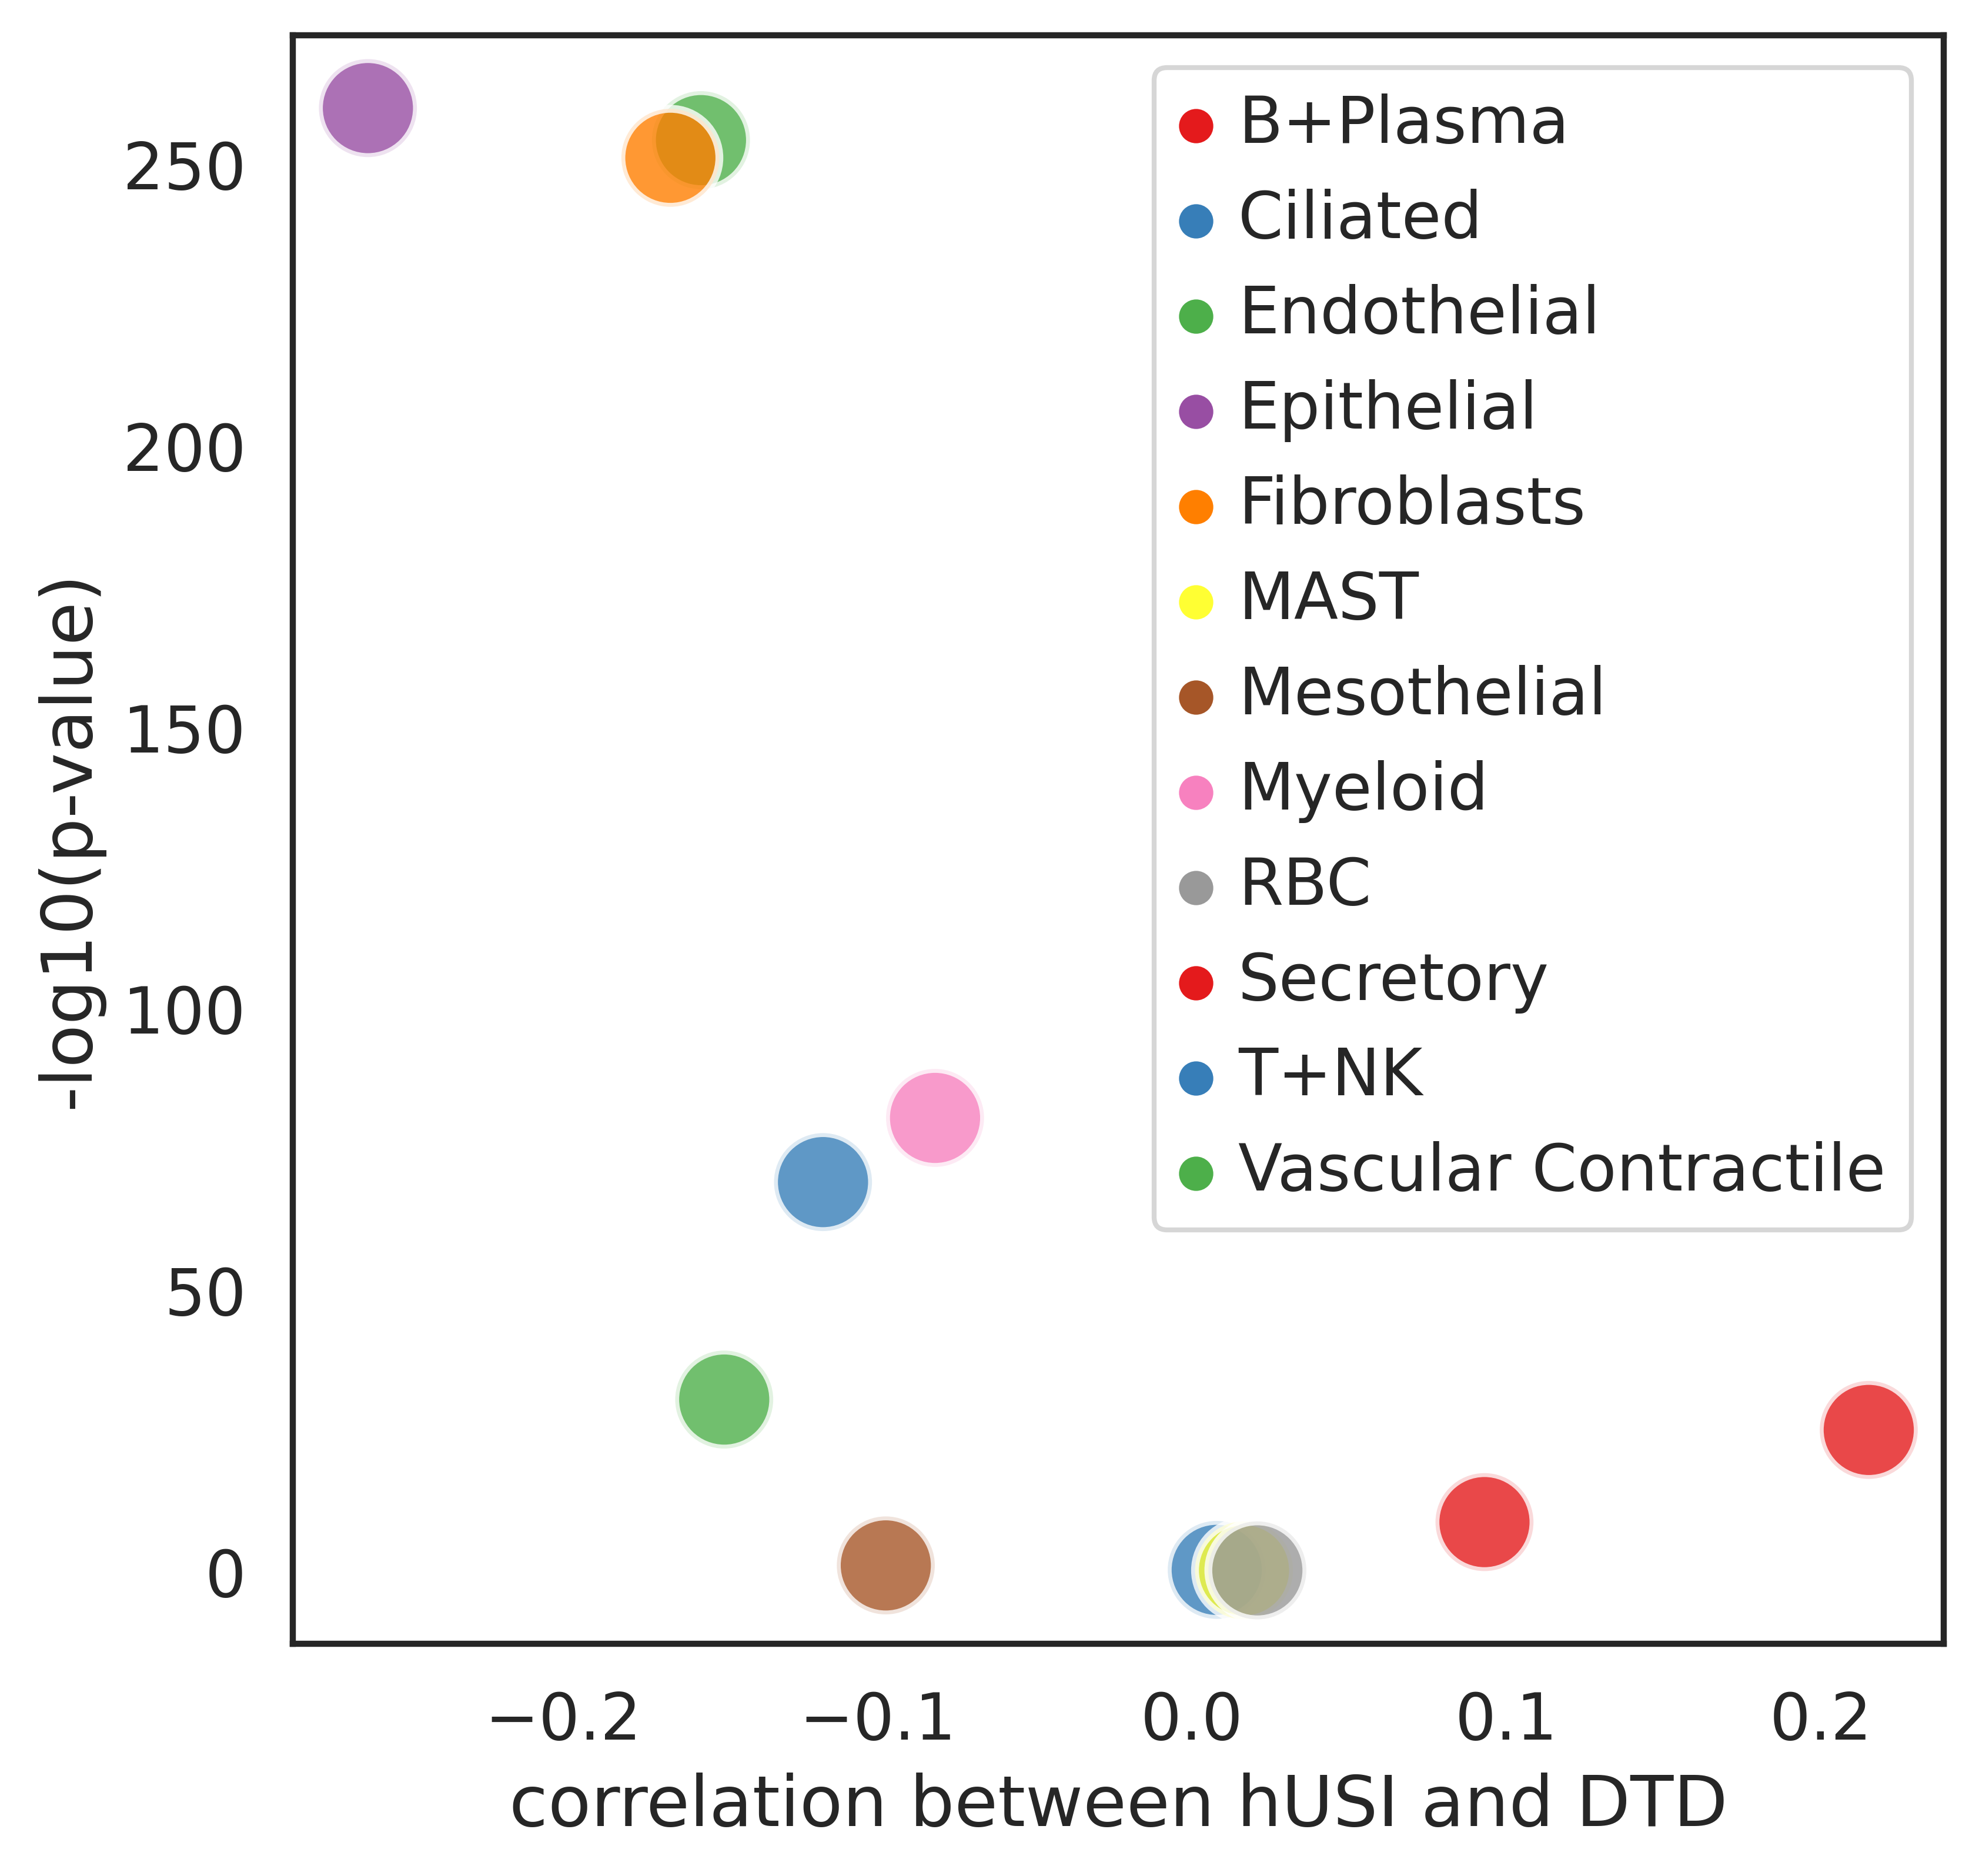

In [360]:
sns.set(rc={'figure.figsize':(6,6)},font_scale=1.2)
sns.set_style("white")
ax = sns.scatterplot(x=c, 
                     y=p, 
                     hue=label,
                     legend='auto',
                     s = 400,
                     alpha=0.8,
                     palette=sns.color_palette("Set1", 12))
plt.xlabel('correlation between hUSI and DTD')
plt.ylabel('-log10(p-value)')
plt.savefig('/home/wangjing/wangj/codebase/HUSI/Figures/covid-19_1010/figures/Corr_DTD.png',dpi=300)
plt.show()

In [ ]:
adata.obs['Progress'] = pd.Categorical(['severe' if i <  15 else 'moderate' for i in adata.obs.DTD],categories=['moderate','severe'],ordered=True)

In [361]:
len(mm_l2)

14638

In [ ]:
from statannot import add_stat_annotation
import itertools
### boxplot significant: hUSI State Clsuter
sns.set(rc={'figure.figsize':(20,10)},font_scale=2)
sns.set_style("white")
ax = sns.boxplot(x='Cluster',hue= 'Progress',y='hUSI',data= adata.obs,palette=['#457b9d',"#bc4749"])
ax.set(xlabel=None)
# ax.set(xticklabels=[])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
pairs = []
for clu in ['B+Plasma', 'Ciliated', 'Endothelial', 'Epithelial', 'Fibroblasts','MAST', 'Myeloid', 'RBC', 'Secretory', 'T+NK','Vascular Contractile']:
    pair = []
    for state in adata.obs.Progress.unique():
        pair.append((clu,state))
    pairs = pairs+list(itertools.combinations(pair, 2))
add_stat_annotation(ax, data=adata.obs, x="Cluster", y="hUSI",hue='Progress',
                    box_pairs=pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2,
                    comparisons_correction = "bonferroni",line_offset_to_box=0.02,line_offset=0.01)
plt.xticks(rotation=45, ha='right')
plt.savefig('/home/wangjing/wangj/codebase/HUSI/Figures/covid-19_1010/figures/boxplot_hUSI.png',dpi=300)
plt.show()